# Projet MI201 - Détection de « topping » sur pizza

André COSTA WERNECK 

Joaquim MINARELLI GASPAR

Leonardo GRECO PICOLI

ENSTA Paris - Institut Polytechnique de Paris

25/01/2023

# Introduction

C'est un fait que l'un des aliments les plus consommés et les plus appréciés du monde est la pizza. Chaque individu a son propre goût et, par conséquent, il existe d'énormes variétés de pizzas avec les ingrédients les plus variés possibles. Ainsi, à partir du jeu de données "pizzaGAN" fourni par le MIT, nous avons proposé un identificateur d'ingrédients de pizza basé sur des techniques d'apprentissage automatique, et plus particulièrement sur l'apprentissage profond. 

Le problème est donc un problème de classification à étiquettes multiples, chaque étiquette étant représentée par un ingrédient présent dans la pizza. Pour le résoudre, nous utilisons d'abord un jeu de données synthétique, avec des images de pizzas générées artificiellement, puis un jeu de données avec des photos de pizzas réelles. L'objectif était donc d'identifier et de classer les ingrédients de la meilleure façon possible et de comparer la capacité de généralisation du modèle pour les images synthétiques et pour les images réelles.

Ainsi, après avoir testé différentes architectures de réseau, nous avons choisi d'implémenter une variation d'un Resnet préappris. La nouvelle structure du modèle sera expliquée en détail ci-dessous, mais, en résumé, nous avons modifié la dernière couche de manière à pouvoir résoudre plusieurs problèmes binaires en parallèle, ce qui configure, au final, une solution à un problème à étiquettes multiples.

Enfin, il a été possible d'observer que le modèle était capable de distinguer efficacement chaque ingrédient et qu'il présentait un peu plus de difficultés d'apprentissage pour le modèle avec des images réelles, ce qui était attendu. Malgré cela, les deux résultats ont été extrêmement satisfaisants.



# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
import os

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
PROJ_DIR_Leo = '/content/gdrive/MyDrive/ENSTA/ML/Projet/'
PROJ_DIR_Joaquim = '/content/gdrive/MyDrive/Ensta/MI201/Projet/'
PROJ_DIR_Andre = '/content/gdrive/MyDrive/MI201/pizza/Projet/' 

# Modifier ici pour ton ordi
PROJ_DIR = PROJ_DIR_Joaquim

sys.path.append(PROJ_DIR)
os.path.exists(PROJ_DIR)

True

In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

# Progress bar
from tqdm.notebook import tqdm

# Image
from PIL import Image

# Librairies scientifique et visualisation utiles standard
import numpy as np
import matplotlib.pyplot as plt
import random

# Confusion matrix heatmap
import seaborn as sn

# Pandas
import pandas as pd

In [ ]:
# Unzip code - don't execute (already unzipped)
#!unzip '/content/gdrive/MyDrive/ENSTA/ML/Projet/pizzaGANsyntheticdata.zip' -d '/content/gdrive/MyDrive/ENSTA/ML/Projet/Dataset'
#!unzip '/content/gdrive/MyDrive/Ensta/MI201/Projet/pizzaGANdata.zip' -d '/content/gdrive/MyDrive/Ensta/MI201/Projet/Dataset_reel'

#Partie 1 - Creation du modèle

# Création du modèle de réseau neuronal convolutif

Pour résoudre le problème, un réseau neuronal convolutif pré-entraîné a été utilisé (resnet34), composé de blocs de convolution séquentiels, puis de blocs de regroupement et enfin d'une couche linéaire avec 512 entrées et 1000 sorties.
Mais comme nous avons un problème de classification multi-classes, il est nécessaire de créer une dernière couche de neurones binaires qui classe la présence d'un certain ingrédient dans la pizza ("oui" ou "non").

Ainsi, la dernière couche de resnet34 a été supprimée, donnant lieu à une couche de classification binaire avec deux "out features" possibles pour chaque ingrédient (0 ou 1).
A partir de ce modèle de réseau, il est possible d'implémenter la fonction de coût "CrossEntropyLoss".

En résumé, la resnet34 a été utilisé comme "backbone", et a été adapté pour convenir à notre solution de problème et à notre format de données.

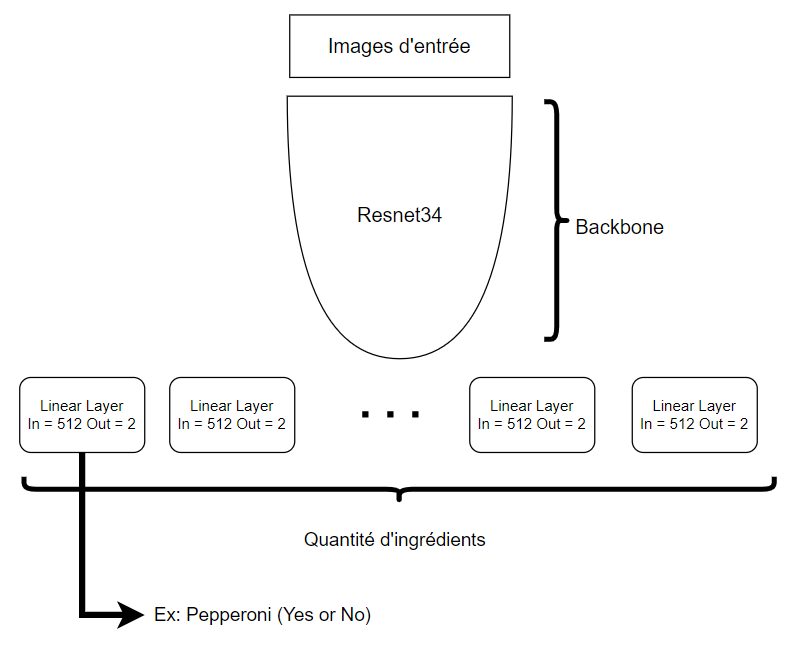

In [ ]:
class MultilabelClassifier(nn.Module):
    def __init__(self, list_ingredients):
        super(MultilabelClassifier, self).__init__()
        self.resnet = models.resnet34(weights='ResNet34_Weights.DEFAULT')
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))

        self.classifiers = {
            ingredient: nn.Sequential(
              nn.Dropout(p=0.2),
              nn.Linear(in_features=512, out_features=2)
            ) for ingredient in list_ingredients
        }

    def cuda(self):
        super().cuda()
        [classifier.cuda() for classifier in self.classifiers.values()]
        return self

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        forward = {ingredient: classifier(x) for ingredient, classifier in self.classifiers.items()}

        return forward

# Training Function

La fonction "**train_val**" reçoit 5 paramètres principaux : 
- **model**: le modèle à entraîner et à évaluer. Correspond à un MultilabelClassifier précédemment défini ;
- **lr_rate** : Taux d'apprentissage, représente le taux d'apprentissage du modèle pendant la formation et la rétropropagation.
- **epochs** : représente la valeur des epochs pour la formation et la validation : combien de fois l'ensemble de données sera formé ;
- **train_loader** : Instance de la classe Pytorch Dataloader qui contient le jeu de données d'entraînement.
- **val_loader** : Instance de la classe Pytorch Dataloader qui contient le jeu de données de validation ;

La fonction train_val renvoie un tuple avec 2 dictionnaires contenant la "loss", la "accuracy" et d'autres métriques qui sont utilisées ultérieurement pour montrer les résultats de la formation et de la validation du modèle.

La fonction train_val utilise 3 fonctions auxiliaires:
1. *criterion*(): Responsable de la comparaison des sorties prédites avec les étiquettes attendues pour chaque ingrédient en utilisant la "Loss function" passée en paramètre, il calcule et renvoie la somme des "losses" pour tous les ingrédients du "batch".
2. *metrics*(): en utilisant les sorties prédites du modèle, on applique les fonctions softmax et argmax avec les logits, et on crée un dictionnaire comparant les résultats de l'apprentissage avec les étiquettes attendues, contenant les clés et les quantités suivantes pour chaque ingrédient : TP (True Positive), TN (True Negatives), FP (False Positive), FN (False Negatives)
3. *accuracy*(): détermine la précision à partir des "metrics", pour chaque ingrédient, en appliquant la fonction A = (TP + TN) / (TP + TN + FP + FN).

La fonction train_val fonctionne comme suit :
1. À chaque "epoch" d'exécution, les "batches" prédéfinis avec les images et les cibles sont instanciés ;
2. Chaque "batch" est envoyé au réseau convolutif MultilabelClassifier et renvoie les sorties prédites après avoir exécuté la fonction "forward".
3. La fonction criterion() est appelée en passant la fonction "nn.CrossEntropyLoss" pour déterminer la "loss" de chaque "batch".
4. La métohde de "Bakpropagation" est effectuée. 
5. Après l'étape d'apprentissage, une étape de validation est également effectuée, afin de comparer les données d'apprentissage et de validation et de surveiller un éventuel cas de "Overfitting" à une époque donnée.

In [ ]:
def criterion(loss_func,outputs,pictures):
  losses = 0
  for i, ing in enumerate(outputs):
    expected = pictures['labels'][ing].type(torch.LongTensor).cuda()
    losses += loss_func(outputs[ing], expected)
  return losses

def metrics(outputs,pictures):
  metrics = {
      "total": {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
  }

  for i, ing in enumerate(outputs):
    expected = pictures['labels'][ing].type(torch.LongTensor).cuda()
    out_softmax = torch.softmax(outputs[ing], dim=-1)
    predicted = torch.argmax(out_softmax, dim=-1)
    
    true_positives = sum((expected == 1) & (predicted == 1)).item()
    false_positives = sum((expected == 0) & (predicted == 1)).item()
    true_negatives = sum((expected == 0) & (predicted == 0)).item()
    false_negatives = sum((expected == 1) & (predicted == 0)).item()
    
    metrics[ing] = {"tp": true_positives, "fp": false_positives, "tn": true_negatives, "fn": false_negatives}
    metrics["total"]["tp"] += true_positives
    metrics["total"]["fp"] += false_positives
    metrics["total"]["tn"] += true_negatives
    metrics["total"]["fn"] += false_negatives

  return metrics

def sum_metrics(metrics, metrics_i):
  total = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
  for ing in metrics_i.keys():
    if (ing not in metrics):
      metrics[ing] = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}

    metrics[ing]["tp"] += metrics_i[ing]["tp"]
    metrics[ing]["fp"] += metrics_i[ing]["fp"]
    metrics[ing]["tn"] += metrics_i[ing]["tn"]
    metrics[ing]["fn"] += metrics_i[ing]["fn"]

def accuracy(metrics):
  accuracy = {}
  for ing in metrics.keys():
    accuracy[ing] = metrics[ing]["tp"] + metrics[ing]["tn"]
    accuracy[ing] = accuracy[ing] / sum([value for value in metrics[ing].values()])
  return accuracy

def train_val(model,lr_rate,epochs,train_loader, val_loader):
  num_epochs = epochs
  train_data = {"losses": [], "accuracy": [], "metrics": {}}
  val_data = {"losses": [], "accuracy": [], "metrics": {}}

  optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
  num_train_batches = len(train_loader)
  num_val_batches = len(val_loader)

  loss_func = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):
    metrics_train = {}
    metrics_val = {}
    # training 
    model.train()
    pbar = tqdm(enumerate(train_loader), desc=f'Epoch:{epoch+1}', total=num_train_batches, leave=True)
    epoch_losses = [] 
    for i, pictures in pbar:
      images = pictures['image'].cuda()
      
      outputs = model(images)

      loss = criterion(loss_func,outputs, pictures)
      epoch_losses.append(loss.item())
      
      metrics_i = metrics(outputs, pictures)
      sum_metrics(metrics_train, metrics_i)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      pbar.set_postfix({'loss': f'{loss.item():.4f}', **accuracy(metrics_train)})
    
    avg_loss = np.mean(epoch_losses)
    avg_accuracy = accuracy(metrics_train)["total"]
    train_data["losses"].append(avg_loss)
    train_data["accuracy"].append(avg_accuracy)

    # validation
    epoch_losses = [] 
    model.eval()
    pbar = tqdm(enumerate(val_loader), desc=f'Epoch:{epoch+1}', total=num_val_batches, leave=True)
    for i, pictures in pbar:
      images = pictures['image'].cuda()
      
      outputs = model(images.cuda())

      val_loss = criterion(loss_func,outputs, pictures)
      epoch_losses.append(val_loss.item())

      metrics_i = metrics(outputs, pictures)
      sum_metrics(metrics_val, metrics_i)
      
      pbar.set_postfix({'loss': f'{loss.item():.4f}', 'val_loss': f'{val_loss.item():.4f}'}, **accuracy(metrics_val))
    
    avg_loss = np.mean(epoch_losses)
    avg_accuracy = accuracy(metrics_val)["total"]
    val_data["losses"].append(avg_loss)
    val_data["accuracy"].append(avg_accuracy)

  train_data["metrics"] = metrics_train
  val_data["metrics"] = metrics_val 
  return train_data, val_data

# Test Function

La fonction de **test** utilise le modèle pré-entraîné et les images de test définies par le paramètre "test_loader" pour tester le modèle et renvoie les indicateurs de "loss", "accuracy" et les métriques de vrais positifs, vrais négatifs, faux positifs et faux négatifs pour chaque ingrédient. 

La fonction **test_ingredients** trace 5 images de pizzas et produit les ingrédients attendus respectifs, et utilise le modèle entraîné pour produire les ingrédients prédits à des fins de comparaison. 

In [ ]:
def test(model, test_loader):
  test_data = {"loss": 0, "accuracy": 0, "metrics": {}}

  loss_func = nn.CrossEntropyLoss()
  losses = []
  metrics_test = {}

  model.eval()
  pbar = tqdm(enumerate(test_loader), total=len(test_loader), leave=True)
  for i, pictures in pbar:
    images = pictures['image'].cuda()
    
    outputs = model(images.cuda())

    test_loss = criterion(loss_func,outputs, pictures)
    losses.append(test_loss.item())

    metrics_i = metrics(outputs, pictures)
    sum_metrics(metrics_test, metrics_i)
    
    pbar.set_postfix({'test_loss': f'{test_loss.item():.4f}'}, **accuracy(metrics_test))
  
  avg_loss = np.mean(losses)
  avg_accuracy = accuracy(metrics_test)["total"]
  test_data["loss"] = avg_loss
  test_data["accuracy"] = avg_accuracy
  test_data["metrics"] = metrics_test
  return test_data

def get_predicted_ingredients(outputs, idx):
  predicted_ingredients = []
  for ing in outputs:
    out_softmax = torch.softmax(outputs[ing], dim=-1)
    predicted = torch.argmax(out_softmax, dim=-1)
    if (predicted[idx]):
      predicted_ingredients.append(ing)

  return predicted_ingredients

def test_ingredients(model, test_loader):
  pictures = next(iter(test_loader))
  for idx in [30, 7, 8, 9, 10]:
    images = pictures['image']
    output_model = model(images.cuda())

    image_pizza = pictures['image'][idx]

    predicted_ingredients = get_predicted_ingredients(output_model, idx)
    expected_ingredients = []
    labels = pictures['labels']
    for ing in labels.keys():
      if (labels[ing][idx]):
        expected_ingredients.append(ing)

    print("Expected ingredients: ", expected_ingredients)
    print("Predicted ingredients: ", predicted_ingredients)
    plt.imshow(image_pizza.permute(1,2,0))
    plt.show()


# Partie 2 - Tests avec une base de données de pizzas synthétiques

Pour la partie d'importation de données, toutes les images ont été converties en RGB (en s'assurant que l'image a une profondeur de 3) et toutes ont été réduites à une dimension de 256x256.
'
Les données du dataset ont été séparées en "train and validation" (75 % de train et 25 % de validation).

In [ ]:
class PizzaDataSet(Dataset):
    def __init__(self, dir, transform):
        self.main_dir = os.path.join(PROJ_DIR, 'Dataset/syntheticDataset', dir)
        self.transform = transform
        self.all_imgs = os.listdir(os.path.join(self.main_dir, 'images'))
        self.all_imgs.sort()
        self.all_labels = torch.tensor(np.loadtxt(os.path.join(self.main_dir, f'{dir}Labels.txt')))
        self.ingredients = ['pepperoni','champignon','poivron','olives','persil','bacon','broccoli','ananas','tomate','oignon']

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, 'images', self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        
        labels = {ingredient:value for ingredient, value in zip(self.ingredients, self.all_labels[idx])}
        
        sample = {'image':tensor_image, 'labels': labels}
        return sample

## Création de pizzas datasets


In [ ]:
transform_pizza = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((256, 256))
])

train_val_pizza_dataset = PizzaDataSet('train', transform=transform_pizza)
train_dataset_size = len(train_val_pizza_dataset) * 75 // 100
val_dataset_size = len(train_val_pizza_dataset) - train_dataset_size
train_pizza_dataset, val_pizza_dataset = torch.utils.data.random_split(train_val_pizza_dataset, [train_dataset_size , val_dataset_size])
test_pizza_dataset = PizzaDataSet('test', transform=transform_pizza)

batch_size = 64
train_pizza = DataLoader(train_pizza_dataset, batch_size=batch_size, shuffle=False)
val_pizza = DataLoader(val_pizza_dataset, batch_size=batch_size, shuffle=False)
test_pizza = DataLoader(test_pizza_dataset, batch_size=batch_size, shuffle=False)

## Création du modèle

In [ ]:
modelSynthetique = MultilabelClassifier(train_val_pizza_dataset.ingredients).cuda()

## Phase d'entraînement du modèle

In [ ]:
train_data, val_data = train_val(modelSynthetique,0.0001,10,train_pizza, val_pizza)

Epoch:1:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:2:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:3:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:4:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:5:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:6:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:7:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:8:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:9:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch:10:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch:10:   0%|          | 0/20 [00:00<?, ?it/s]

## Plotting les résultats

### Plotting graph Loss x Epochs


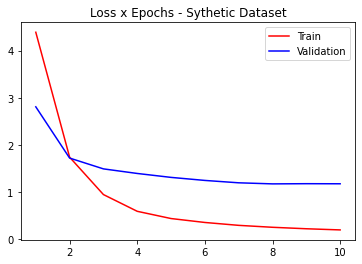

In [ ]:
# Plot losses
y_train_losses = train_data["losses"]
y_val_losses = val_data["losses"]
x_epochs = range(1, len(y_train_losses) + 1)

fig, axs = plt.subplots()

axs.set_title("Loss x Epochs - Sythetic Dataset")
axs.plot(x_epochs, y_train_losses, 'r', label='Train') 
axs.plot(x_epochs, y_val_losses, 'b', label="Validation")
axs.legend()
plt.show()

### Plotting graph Accuracy x Epochs 

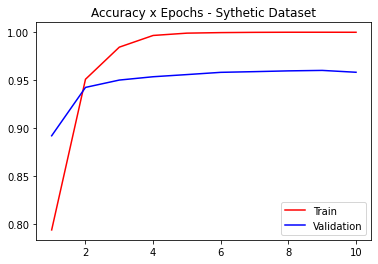

In [ ]:
# Plot accuracy
y_train_accuracy = train_data["accuracy"]
y_val_accuracy = val_data["accuracy"]
x_epochs = range(1, len(y_train_accuracy) + 1)

fig, axs = plt.subplots()

axs.set_title("Accuracy x Epochs - Sythetic Dataset")
axs.plot(x_epochs, y_train_accuracy, 'r', label='Train') 
axs.plot(x_epochs, y_val_accuracy, 'b', label="Validation")
axs.legend()
plt.show()

### Plotting graph Accuracy x Ingredient

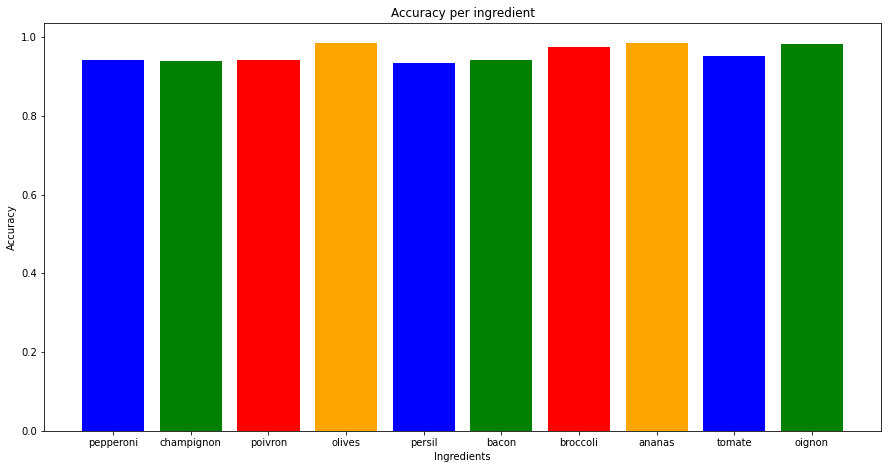

In [ ]:
accuracy_val_data = accuracy(val_data["metrics"])

fig, ax = plt.subplots()

ingredients_list = list(accuracy_val_data.keys())[1:]
accuracy_list = list(accuracy_val_data.values())[1:]
# bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['blue', 'green', 'red', 'orange']

fig.set_size_inches(15, 7.5)

ax.bar(ingredients_list, accuracy_list, color=bar_colors)
ax.set_ylabel('Accuracy')
ax.set_xlabel("Ingredients")
ax.set_title('Accuracy per ingredient')
# ax.legend(title='Ingredients')

plt.show()

## Testing the model

In [ ]:
test_data = test(modelSynthetique,test_pizza)

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame.from_dict(test_data['metrics'])

,total,pepperoni,champignon,poivron,olives,persil,bacon,broccoli,ananas,tomate,oignon
tp,1386,119,121,123,141,133,139,151,140,157,162
fp,55,4,3,3,0,12,2,3,2,23,3
tn,3377,356,348,342,351,340,333,325,346,310,326
fn,152,18,25,29,5,12,23,18,9,7,6


In [ ]:
print(f'Accuracy : %.2f' % (test_data['accuracy']*100), "%")
print('Loss : ',test_data['loss'])

Accuracy : 95.84 %
Loss :  1.1977540329098701


## Comparaison Expected x Predicted

Expected ingredients:  ['pepperoni', 'poivron', 'ananas', 'tomate']
Predicted ingredients:  ['pepperoni', 'poivron', 'ananas', 'tomate']


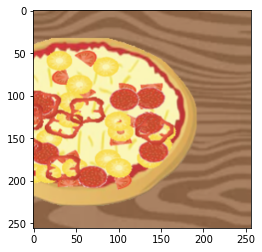

Expected ingredients:  ['champignon', 'olives']
Predicted ingredients:  ['champignon', 'olives']


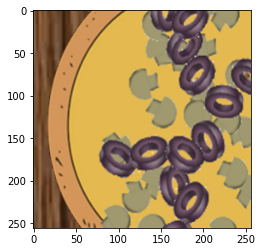

Expected ingredients:  ['persil', 'bacon', 'broccoli', 'tomate', 'oignon']
Predicted ingredients:  ['persil', 'bacon', 'broccoli', 'tomate']


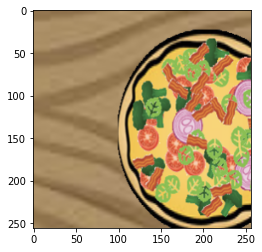

Expected ingredients:  ['persil', 'oignon']
Predicted ingredients:  ['persil', 'oignon']


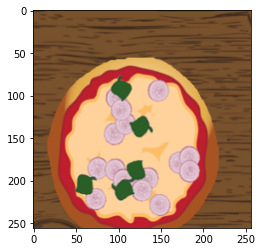

Expected ingredients:  ['pepperoni', 'persil', 'bacon']
Predicted ingredients:  ['pepperoni', 'persil', 'bacon', 'tomate']


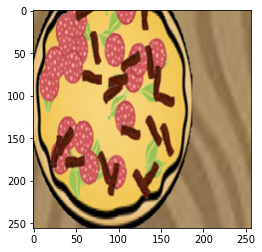

In [ ]:
test_ingredients(modelSynthetique, test_pizza)

# Partie 3 - Tests avec des images de pizzas réelles

In [ ]:
class PizzaReelDataSet(Dataset):
    def __init__(self, transform):
        self.main_dir = os.path.join(PROJ_DIR, "Dataset_reel/pizzaGANdata")
        self.transform = transform
        self.all_imgs = os.listdir(os.path.join(self.main_dir, 'images'))
        self.all_imgs.sort()        
        self.all_labels = torch.tensor(np.loadtxt(os.path.join(self.main_dir, 'imageLabels.txt')))
        self.ingredients = ['Pepperoni', 'Bacon', 'Mushrooms', 'Onions', 'Peppers', 'Black olives', 'Tomatoes', 'Spinach', 'Fresh basil', 'Arugula', 'Broccoli', 'Corn', 'Pineapple']

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, 'images', self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        
        labels = {ingredient:value for ingredient, value in zip(self.ingredients, self.all_labels[idx])}
        
        sample = {'image':tensor_image, 'labels': labels}
        return sample

## Création de pizzas datasets

In [ ]:
transform_pizza = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Resize((256, 256))
])

pizza_dataset = PizzaReelDataSet(transform=transform_pizza)

train_dataset_size = len(pizza_dataset) * 6 // 10
val_dataset_size = len(pizza_dataset) * 2 // 10
test_dataset_size = len(pizza_dataset) - train_dataset_size - val_dataset_size
train_pizza_dataset, val_pizza_dataset, test_pizza_dataset = torch.utils.data.random_split(pizza_dataset, [train_dataset_size , val_dataset_size, test_dataset_size])

batch_size = 64
train_pizza = DataLoader(train_pizza_dataset, batch_size=batch_size, shuffle=False)
val_pizza = DataLoader(val_pizza_dataset, batch_size=batch_size, shuffle=False)
test_pizza = DataLoader(test_pizza_dataset, batch_size=batch_size, shuffle=False)

## Création du modèle

In [ ]:
modelReels = MultilabelClassifier(pizza_dataset.ingredients).cuda()

## Phase d'entraînement du modèle

In [ ]:
train_data, val_data = train_val(modelReels,0.0001,10,train_pizza, val_pizza)

Epoch:1:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:1:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:2:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:2:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:3:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:3:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:4:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:4:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:5:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:5:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:6:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:6:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:7:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:7:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:8:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:8:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:9:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:9:   0%|          | 0/29 [00:00<?, ?it/s]

Epoch:10:   0%|          | 0/87 [00:00<?, ?it/s]

Epoch:10:   0%|          | 0/29 [00:00<?, ?it/s]

## Plotting les résultats

### Plotting graph Loss x Epochs

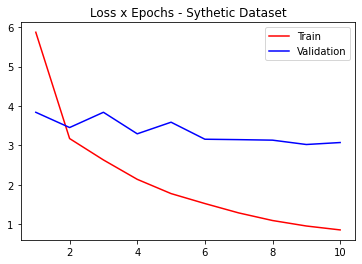

In [ ]:
# Plot losses
y_train_losses = train_data["losses"]
y_val_losses = val_data["losses"]
x_epochs = range(1, len(y_train_losses) + 1)

fig, axs = plt.subplots()

axs.set_title("Loss x Epochs - Sythetic Dataset")
axs.plot(x_epochs, y_train_losses, 'r', label='Train') 
axs.plot(x_epochs, y_val_losses, 'b', label="Validation")
axs.legend()
plt.show()

### Plotting graph Accuracy x Epochs

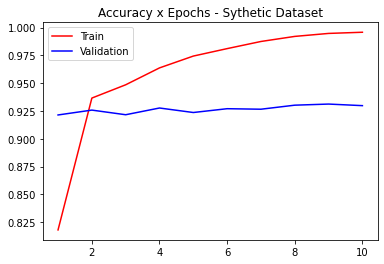

In [ ]:
# Plot accuracy
y_train_accuracy = train_data["accuracy"]
y_val_accuracy = val_data["accuracy"]
x_epochs = range(1, len(y_train_accuracy) + 1)

fig, axs = plt.subplots()

axs.set_title("Accuracy x Epochs - Sythetic Dataset")
axs.plot(x_epochs, y_train_accuracy, 'r', label='Train') 
axs.plot(x_epochs, y_val_accuracy, 'b', label="Validation")
axs.legend()
plt.show()

### Plotting graph Accuracy x Ingredient

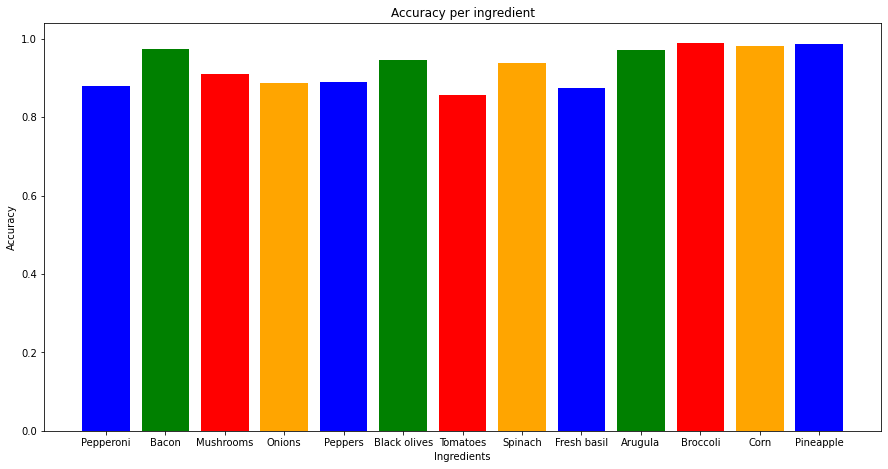

In [ ]:
accuracy_val_data = accuracy(val_data["metrics"])

fig, ax = plt.subplots()

ingredients_list = list(accuracy_val_data.keys())[1:]
accuracy_list = list(accuracy_val_data.values())[1:]
# bar_labels = ['red', 'blue', '_red', 'orange']
bar_colors = ['blue', 'green', 'red', 'orange']

fig.set_size_inches(15, 7.5)

ax.bar(ingredients_list, accuracy_list, color=bar_colors)
ax.set_ylabel('Accuracy')
ax.set_xlabel("Ingredients")
ax.set_title('Accuracy per ingredient')
# ax.legend(title='Ingredients')

plt.show()

## Testing the model

In [ ]:
test_data = test(modelReels,test_pizza)

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame.from_dict(test_data['metrics'])

,total,Pepperoni,Bacon,Mushrooms,Onions,Peppers,Black olives,Tomatoes,Spinach,Fresh basil,Arugula,Broccoli,Corn,Pineapple
tp,968,269,0,57,51,71,118,219,18,132,14,0,19,0
fp,597,51,2,33,71,102,54,111,42,90,21,2,12,6
tn,21398,1367,1807,1628,1594,1587,1622,1384,1710,1491,1784,1825,1781,1818
fn,1009,157,35,126,128,84,50,130,74,131,25,17,32,20


In [ ]:
print(f'Accuracy : %.2f' % (test_data['accuracy']*100), "%")
print('Loss : ',test_data['loss'])

Accuracy : 93.30 %
Loss :  2.8961355357334533


## Comparaison Expected x Predicted

Expected ingredients:  ['Pepperoni']
Predicted ingredients:  ['Pepperoni']


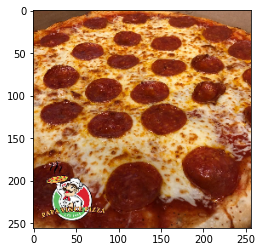

Expected ingredients:  []
Predicted ingredients:  ['Pepperoni']


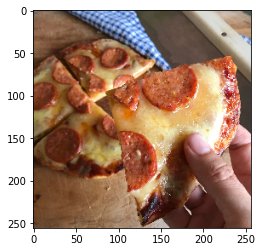

Expected ingredients:  ['Pepperoni', 'Fresh basil']
Predicted ingredients:  ['Pepperoni', 'Fresh basil']


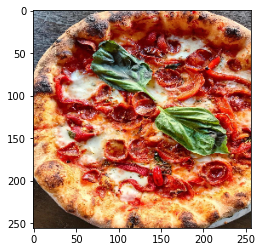

Expected ingredients:  ['Pepperoni', 'Onions', 'Peppers', 'Corn']
Predicted ingredients:  ['Onions', 'Peppers']


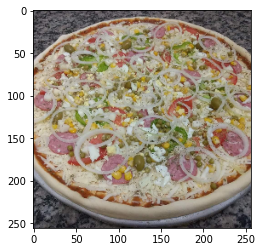

Expected ingredients:  ['Onions', 'Black olives']
Predicted ingredients:  ['Black olives']


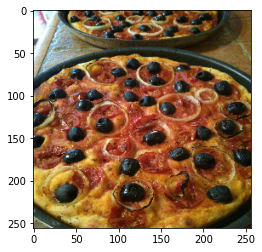

In [ ]:
test_ingredients(modelReels, test_pizza)

# Conclusion



Tant avec la base de pizzas synthétiques qu'avec la base de vraies pizzas, le réseau de neurones a obtenu une convergence très rapide, atteignant plus de 90% de précision sur environ 3 époques, et avec une très petite erreur finale par rapport à la taille de l'ensemble de données. .
Au final, le réseau formé avec les valeurs synthétiques a obtenu une précision de 96%, tandis que le réel était de 93%, ce qui est conforme aux attentes, compte tenu de la difficulté et de la variété des images contenues dans le dataset réel.

Il est intéressant de noter que, dans la base de données des pizzas réelles, il y avait des pizzas considérées comme "sans ingrédients", et qui ont été classées par le réseau de neurones, ce qui montre son efficacité pour la reconnaissance d'images.